# HoeNN Demo - VQA

In this demo we will load the pretrained weight for our VQA model, and run through a few examples from our dataset. First things first, import all the libraries.

In [1]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import pickle

from data_loader import get_loader  
from vqa import VQA

Next, we want to select our device (1080Ti preferably)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Utilizing: {}".format(device))

Utilizing: cuda


We next select our data loader to gather some sample data as well as our checkpoint

In [3]:
dataset_root_dir = './datasets/'
checkpoint_path = './models/demo.ckpt'

We create a handy function that will allow us to visualize the data

In [4]:
def myimshow(image, ax=plt): 
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

We now load out model using a checkpoint, and our selected hyperparameters.

In [5]:
qst_vocab_size = 17856
ans_vocab_size = 1000

activation = nn.Tanh()
dropout = nn.Dropout(0.5)
combination = torch.mul

model = VQA(activation, dropout, combination, ans_vocab_size, qst_vocab_size).to(device)

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

Next, we load our serialized test data. This data contains 256 randomly sampled data points, including an image, answer labels, and questions

In [6]:
infile = open('./pickle/datapoint', 'rb')
our_datapoint = pickle.load(infile)
infile.close()

infile = open('./pickle/qst_vocab', 'rb')
qst_vocab = pickle.load(infile)
infile.close()

infile = open('./pickle/ans_vocab', 'rb')
ans_vocab = pickle.load(infile)
infile.close()

The following cell randomly selects a point from the previous dataset, and runs our pretrained network on it. You can observe the output below. Run this as many times as you want, try it out!

Question: is this plant artificial ?
Correct: no
Predicted: no


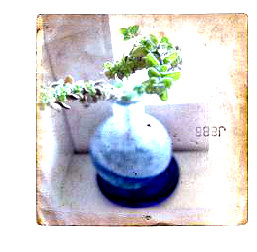

In [7]:
idx = np.random.randint(0,255)

valid_q_t = our_datapoint['question'][idx]
valid_al_t = our_datapoint['answer_label'][idx].item()
valid_im = our_datapoint['image'][idx,:,:,:]

myimshow(valid_im)

valid_q_list = []
for q_idx in valid_q_t:
    if (qst_vocab.idx2word(q_idx) == '<pad>'):
        break
    valid_q_list.append(qst_vocab.idx2word(q_idx))
valid_q = ' '.join(valid_q_list)

valid_al = ans_vocab.idx2word(valid_al_t)

val_output = model(valid_im.view(1,3,224,224).to(device), valid_q_t.view(1,30).to(device))

_, out_al_t = torch.max(val_output,1)

out_al = ans_vocab.idx2word(out_al_t)

print("Question: {}".format(valid_q))
print("Correct: {}".format(valid_al))
print("Predicted: {}".format(out_al))